In [64]:
import random
import pandas as pd
import numpy as np
import warnings
from math import log
import os
import random
import matplotlib.pyplot as plt
from tqdm import trange
import datetime, time
from utils import *
from collections import Counter
from scipy import *
import scipy.io as scio
import tensorflow as tf
import logging
from functools import reduce

from tslearn.datasets import CachedDatasets
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from xgboost import XGBClassifier

from scipy.signal import find_peaks
from scipy.stats import wasserstein_distance

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn import preprocessing

from deepwalk import graph
from deepwalk import walks as serialized_walks
import weighted_random_walk
from gensim.models import Word2Vec
from skipgram import Skipgram
import networkx as nx

import psutil
from multiprocessing import cpu_count

warnings.filterwarnings('ignore')

In [3]:
undirected = False
input_format = 'weighted_edgelist'
log_verb = 'INFO'
representation_size = 64   # Number of latent dimensions to learn for each node
workers = 2          # Number of parallel processes
window_size = 5      # Window size of skipgram model
walk_length = 100     # Length of the random walk started at each node
number_walks = 10    # Number of random walks to start at each node
seed = 0             # random seed
shp_len = 10         # shapelet length
shp_num = 100        # number of shapelet in each time series
postive_per = 0.3    # the postive samples rate in dataset
dis_type = 'JS'      #KL or JS or EMD
max_memory_data_size = 1000000000

## 补全时间序列

In [4]:
# dict_ts = get_all_files_ts()

In [5]:
#保存
# np.save('./data/money_laundrying_dataset/TS_amt_bal_dest.npy', dict_ts)

## 计算shapelet

In [6]:
# # if the X and y are not be initiated, then you should run followed code to get X and y
# # else, just read the data.npy file

In [7]:
#gx_dataet
dict_ts = load_ts()
#get Shapelet's input
amounts = []
balances = []
dests = []
labels = []
N_num = sum((pd.DataFrame(dict_ts)).iloc[3,:].values) / postive_per * (1-postive_per)   #negative sample's number (to control the percentage of Negative and Postive)
cnt = 0
for key in list(dict_ts.keys()):
    if dict_ts[key]['label'] == 0:
        cnt += 1
        if cnt > N_num:
            continue
    amounts.append(dict_ts[key]['amounts'])
    balances.append(dict_ts[key]['balances'])
    dests.append(dict_ts[key]['dests'])
    labels.append(dict_ts[key]['label'])
amounts = np.array(amounts)
balances = np.array(balances)
dests = np.array(dests)
labels = np.array(labels)

#Shapelet's input is supposed to be 3 dimensions
amounts = amounts[:,:,np.newaxis]
balances = balances[:,:,np.newaxis]
dests = dests[:,:,np.newaxis]
ts = np.dstack((amounts, balances, dests))
print(amounts.shape, balances.shape, dests.shape, ts.shape, labels.shape)

X = ts[:,:,:1]
y = labels
print(X.shape, y.shape)

# only use the valid value of time series
print('delete the invalid values...')
ts_len = 1000 # set the length of time series
ts_num = X.shape[0]
for i in range(ts_num):
    tmp_ts = X[i,:,:].squeeze()
    tmp_dests = dests[i,:,:].squeeze()
    if min(tmp_ts) == max(tmp_ts) and max(tmp_ts) == 0:
        start_idx = 0
    else:
        start_idx = np.where(tmp_ts == max(tmp_ts))[0][0] - int(ts_len/2)
#         locs = np.where(tmp_ts > np.mean(tmp_ts)+np.std(tmp_ts))
        if start_idx < 0: #too small
            start_idx = 0
        if start_idx + ts_len > X.shape[1]: #too large
            start_idx -= ts_len

    if i == 0:
        new_X = np.array(tmp_ts[start_idx:start_idx+ts_len])
        new_dests = np.array(tmp_dests[start_idx:start_idx+ts_len])
    else:
        new_X = np.vstack((new_X, np.array(tmp_ts[start_idx:start_idx+ts_len])))
        new_dests = np.vstack((new_dests, np.array(tmp_ts[start_idx:start_idx+ts_len])))
    
new_X = np.array(new_X)[:,:,np.newaxis]
new_dests = np.array(new_dests)[:,:,np.newaxis]

d = dict()
d['X'] = new_X
d['y'] = y
ts = np.dstack((new_X, new_dests))
d['ts'] = ts
np.save('./data/money_laundrying_dataset/gx_data_%s.npy'%str(postive_per), d)
print('finished.')

(2500, 3624, 1) (2500, 3624, 1) (2500, 3624, 1) (2500, 3624, 3) (2500,)
(2500, 3624, 1) (2500,)
delete the invalid values...
finished.


In [8]:
#bitcoin_dataset


In [9]:
data = np.load('./data/money_laundrying_dataset/gx_data_%s.npy'%str(postive_per), allow_pickle=True)[()]
X = data['X']
y = data['y']
ts = data['ts']
print(X.shape, y.shape, ts.shape)

(2500, 1000, 1) (2500,) (2500, 1000, 2)


In [10]:
# for i in range(X.shape[0]):
#     plt.subplot(1,2,1)
#     plt.plot(list(range(new_X.shape[1])), new_X[i,:,0])
#     plt.grid()
#     plt.subplot(1,2,2)
#     plt.plot(list(range(X.shape[1])), X[i,:,0])
#     plt.grid()
#     plt.show()

In [11]:
per = sum(y)/y.shape[0]
print('Dataset Percentage of Postive Samples = {}'.format(per))

Dataset Percentage of Postive Samples = 0.3


In [12]:
# Scaler
X = preprocessing.scale(X.squeeze())
X = X[:,:,np.newaxis]
print(X.shape)

(2500, 1000, 1)


In [13]:
n_ts, ts_sz = X.shape[:2]
n_classes = len(set(y))
print(n_ts, ts_sz, n_classes)

2500 1000 2


In [14]:
# shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
#                                                        ts_sz=ts_sz,
#                                                        n_classes=n_classes,
#                                                        l=0.1,
#                                                        r=1)
shapelet_sizes = {shp_len: shp_num}
shapelet_sizes

{10: 100}

In [15]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=100,
                            random_state= 42,
                            verbose=1)
shp_clf.fit(X, y)

Epoch 1/100
157/157 [==============================] - 1s 4ms/step - loss: 12.5268 - binary_accuracy: 0.6376 - binary_crossentropy: 12.5070
Epoch 2/100
157/157 [==============================] - 1s 4ms/step - loss: 3.2439 - binary_accuracy: 0.6656 - binary_crossentropy: 3.2254
Epoch 3/100
157/157 [==============================] - 1s 4ms/step - loss: 5.1220 - binary_accuracy: 0.6300 - binary_crossentropy: 5.1035
Epoch 4/100
157/157 [==============================] - 1s 4ms/step - loss: 3.0722 - binary_accuracy: 0.6548 - binary_crossentropy: 3.0541
Epoch 5/100
157/157 [==============================] - 1s 4ms/step - loss: 4.4592 - binary_accuracy: 0.6476 - binary_crossentropy: 4.4410
Epoch 6/100
157/157 [==============================] - 1s 4ms/step - loss: 2.4108 - binary_accuracy: 0.6724 - binary_crossentropy: 2.3934
Epoch 7/100
157/157 [==============================] - 1s 4ms/step - loss: 5.2032 - binary_accuracy: 0.6460 - binary_crossentropy: 5.1854
Epoch 8/100
157/157 [===========

Epoch 60/100
157/157 [==============================] - 1s 4ms/step - loss: 2.5486 - binary_accuracy: 0.6688 - binary_crossentropy: 2.5328
Epoch 61/100
157/157 [==============================] - 1s 4ms/step - loss: 3.5545 - binary_accuracy: 0.6520 - binary_crossentropy: 3.5392
Epoch 62/100
157/157 [==============================] - 1s 4ms/step - loss: 3.0493 - binary_accuracy: 0.6636 - binary_crossentropy: 3.0338
Epoch 63/100
157/157 [==============================] - 1s 4ms/step - loss: 3.5273 - binary_accuracy: 0.6556 - binary_crossentropy: 3.5117
Epoch 64/100
157/157 [==============================] - 1s 4ms/step - loss: 3.3981 - binary_accuracy: 0.6592 - binary_crossentropy: 3.3829
Epoch 65/100
157/157 [==============================] - 1s 4ms/step - loss: 2.3578 - binary_accuracy: 0.6668 - binary_crossentropy: 2.3429
Epoch 66/100
157/157 [==============================] - 1s 4ms/step - loss: 3.1698 - binary_accuracy: 0.6588 - binary_crossentropy: 3.1544
Epoch 67/100
157/157 [=====

LearningShapelets(batch_size=16, max_iter=100, n_shapelets_per_size={10: 100},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f16a97248b0>,
                  random_state=42, verbose=1, weight_regularizer=0.01)

In [16]:
# the performance of shapelet may influence the final result of our model
pred_labels = shp_clf.predict(X)
print("accuracy:", accuracy_score(y, pred_labels))
print("precision:", precision_score(y, pred_labels))
print('recall:', recall_score(y, pred_labels))
print('f1-score:', f1_score(y, pred_labels))

157/157 [==============================] - 0s 2ms/step
accuracy: 0.782
precision: 0.7871148459383753
recall: 0.37466666666666665
f1-score: 0.5076784101174345


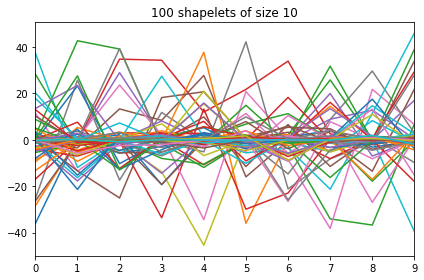

In [17]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])
    #plt.ylim([0,10000])
plt.tight_layout()
plt.show()

In [18]:
#shp_clf.shapelets_.shape
shp_loc = shp_clf.locate(X)
shp_loc.shape

157/157 [==============================] - 0s 1ms/step


(2500, 100)

In [19]:
shp_ts = shp_clf.shapelets_as_time_series_
shp_ts.shape

(100, 10, 1)

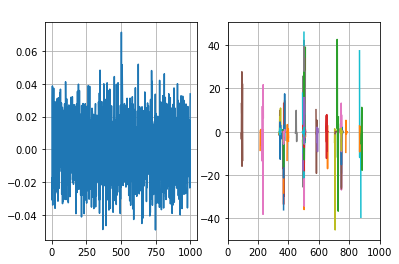

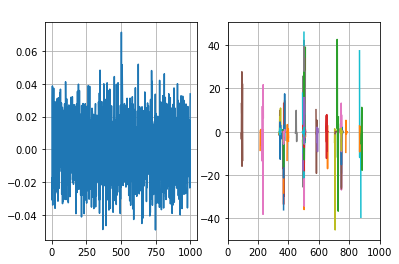

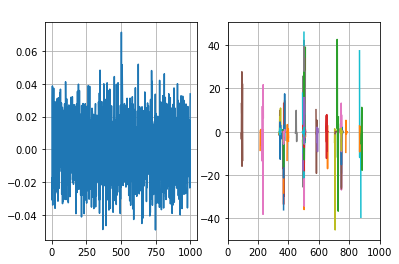

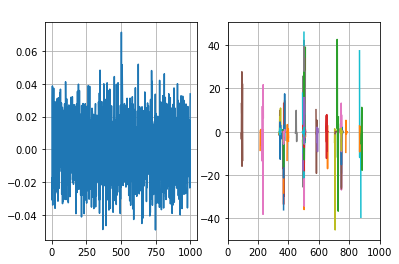

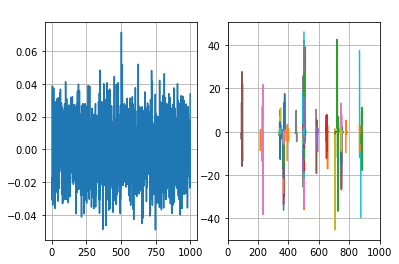

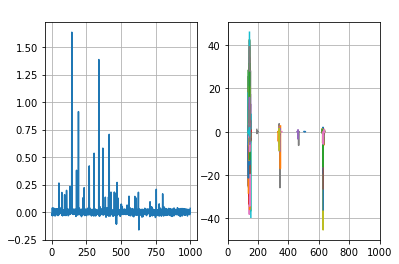

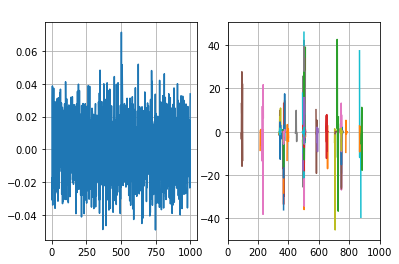

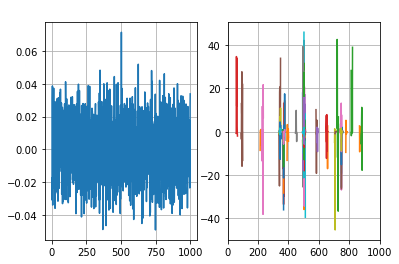

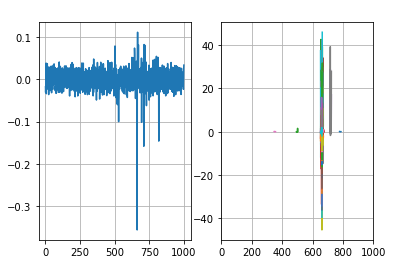

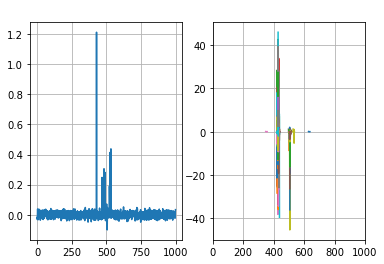

In [20]:
##plot
#the shapelets in timeseries
for i in range(X.squeeze().shape[0])[:10]:
    plt.subplot(1,2,1)
    x = list(range(X.shape[1]))
    values = list(X.squeeze()[i,:])
    plt.plot(x, values, label = 'ts')
    plt.grid()
    plt.title('time series', color='white')
    #plt.show()
    plt.subplot(1,2,2)
    plt.grid()
    for j in range(shp_ts.shape[0]):
        x = list(range(shp_loc[i,j], shp_loc[i,j]+shp_ts.shape[1]))
        values = list(shp_ts[j])
        plt.plot(x, values, label = 'shapelets'+str(j))
        plt.xlim(0, X.shape[1])
        plt.title('shapelet', color='white') 
    #plt.xlim(0,1000)
    #plt.ylim(-10000,10000)
    #plt.legend()
    plt.show()

In [21]:
# the shapelet sequence of each time series
df_shp_loc = pd.DataFrame(shp_loc)
shp_seqs = []
for row in range(df_shp_loc.shape[0]):
    shp_seq = df_shp_loc.sort_values(by=[row], axis=1).columns.tolist()
    shp_seqs.append(shp_seq)
shp_seqs = np.array(shp_seqs)
print(shp_seqs.shape)

(2500, 100)


In [22]:
d_shp = dict()
d_shp['shp_loc'] = shp_loc
d_shp['shp_ts'] = shp_ts
d_shp['shp_seq'] = shp_seqs
d_shp['seq_label'] = y
np.save('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts_{}.npy'.format(shp_len, shp_num, str(postive_per)), d_shp)

## DTW距离

In [23]:
#已经训练好的shapelet与原序列的对应位置和shapelet本身
shp_loc_ts = np.load('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts_{}.npy'.format(shp_len, shp_num, str(postive_per)),\
                    allow_pickle=True)[()]
shp_loc_ts.keys()

dict_keys(['shp_loc', 'shp_ts', 'shp_seq', 'seq_label'])

In [24]:
shp_loc = shp_loc_ts['shp_loc']
shp_ts = shp_loc_ts['shp_ts']
shp_seq = shp_loc_ts['shp_seq']
seq_label = shp_loc_ts['seq_label']
print(shp_loc.shape, shp_ts.shape, shp_seq.shape, seq_label.shape)

(2500, 100) (100, 10, 1) (2500, 100) (2500,)


In [25]:
shp_num = shp_ts.shape[0]
shp_len = shp_ts.shape[1]
print(shp_num, shp_len)

100 10


In [26]:
ts_num = X.shape[0]
w_amt_mat = []
for i in trange(ts_num):
    w_amt = []
    for j in range(shp_num):
        x_amt = X[i, shp_loc[i, j]:shp_loc[i, j]+shp_len, 0]
        y_amt = shp_ts[j,:,0]
        d_amt = dtw_distance(x_amt, y_amt)
        w_amt.append(d_amt)
    w_amt_mat.append(w_amt)
w_amt_mat = np.array(w_amt_mat)
dtw_mat = w_amt_mat
dtw_mat.shape

100%|██████████| 2500/2500 [00:40<00:00, 61.81it/s]


(2500, 100)

In [27]:
# the dtw threshold should not be too small, or there will exist isolate node in Graph,
# meanwhile, it should not be too large as well, because it will be meaningless to set threshold
dtw_threshold = np.mean(dtw_mat)+27
dtw_threshold

61.02282126886406

In [28]:
# if the shapelet can fit time series well(the dtw_threshold larger than threshold),
# then this shaplet should be delete from the shp_seq(use -1 to represent)
for i in trange(ts_num):
    for j in range(shp_num):
        if dtw_mat[i,j] > dtw_threshold: 
            shp_seq[i, j] = -1  

100%|██████████| 2500/2500 [00:00<00:00, 33519.89it/s]


In [29]:
# update the shaplet sequence of time series
shp_loc_ts['shp_seq'] = shp_seq
np.save('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts_{}.npy'.format(shp_len, shp_num, str(postive_per)), shp_loc_ts)

## 转账对象分布

In [30]:
#dest time series
dest_ts = ts[:,:,1]
print(dest_ts.shape)

(2500, 1000)


In [31]:
#获得转账不同对象的频率
def get_freq(shp_dest):
    ZERO = 1e-5
    #shp_dest = [1,2,2,1,4,3]
    freq = Counter(shp_dest)
    #print(freq)
    freq.pop(-1,'no such key')
    freq_arr = np.sort(np.array(list(freq.values())) / len(shp_dest)) #按频率从小到大排序
    need_num = shp_len - freq_arr.shape[0] #需填充的数量
    freq_arr = np.hstack((list(np.zeros(need_num)+ZERO), freq_arr))

    return freq_arr

In [32]:
all_freqs = []
for i in trange(dest_ts.shape[0]):
    freqs = []
    for j in range(shp_num):
        shp_dest = dest_ts[i, shp_loc[i, j]:shp_loc[i, j]+shp_len]
        freq_arr = get_freq(shp_dest)
        freqs.append(freq_arr)
    all_freqs.append(freqs)
all_freqs = np.array(all_freqs)
freq_mat = all_freqs
print(freq_mat.shape)

100%|██████████| 2500/2500 [00:06<00:00, 394.02it/s]


(2500, 100, 10)


In [33]:
# save the result
d_weight = dict()
d_weight['dtw_mat'] = dtw_mat
d_weight['freq_mat'] = freq_mat
np.save('./data/money_laundrying_dataset/shp_{}_{}/tmp_weight_mat_{}.npy'.format(shp_len, shp_num, str(postive_per)), d_weight)

## 构造有向带权图（KL散度/JS散度/Wasserstein距离）

In [34]:
weight_mat = np.load('./data/money_laundrying_dataset/shp_{}_{}/tmp_weight_mat_{}.npy'.format(shp_len, shp_num, str(postive_per)),\
                     allow_pickle=True)
weight_mat = weight_mat[()]
weight_mat.keys()

dict_keys(['dtw_mat', 'freq_mat'])

In [35]:
dtw_mat = weight_mat['dtw_mat']
freq_mat = weight_mat['freq_mat']
print(dtw_mat.shape, freq_mat.shape)

(2500, 100) (2500, 100, 10)


In [36]:
# # 求和
# # calculate weight
# INF = 1e10
# shp_n = shp_loc.shape[1]
# INF = 1e10
# #threshold = np.mean(dtw_mat)+16  #dtw threshold
# shp_n = shp_loc.shape[1]
# edge_mat = np.zeros(shp_n * shp_n)
# edge_mat = edge_mat.reshape(shp_n, shp_n)
    
# for i in trange(shp_seq.shape[0]):
#     for j in range(1,shp_seq.shape[1]):
#         if dtw_mat[i, j-1] > dtw_threshold or dtw_mat[i, j] > dtw_threshold:
#             continue
#         if dis_type == 'JS':
#             distance = JS_divergency(freq_mat[i, j-1, :], freq_mat[i, j, :]) 
#         elif dis_type == 'KL':
#             distance = symmetricalKL(freq_mat[i, j-1, :], freq_mat[i, j, :])
#         else:
#             raise Exception('Wrong Distance Type')
#             break
#         if distance == 0:
#             continue #invalid distance
#         edge_mat[shp_seq[i,j-1]][shp_seq[i,j]] += (1-distance)
# edge_mat = np.array(edge_mat)

In [66]:
dis_type = 'EMD'
# 求平均值
# calculate weight
INF = 1e10
shp_n = shp_loc.shape[1]
edge_mat = []
for i in range(shp_n):
    line = []
    for j in range(shp_n):
        line.append(list())
    edge_mat.append(line)

min_emd, max_emd, emds = 9999, 0, []
for i in trange(shp_seq.shape[0]):
    for j in range(1,shp_seq.shape[1]):
        if dtw_mat[i, j-1] > dtw_threshold or dtw_mat[i, j] > dtw_threshold:
            continue
        if dis_type == 'JS':
            js = JS_divergency(freq_mat[i, j-1, :], freq_mat[i, j, :]) 
            distance = 1 - js
        elif dis_type == 'KL':
            kl = symmetricalKL(freq_mat[i, j-1, :], freq_mat[i, j, :])
            distance = kl
        elif dis_type == 'EMD':
            emd = wasserstein_distance(freq_mat[i, j-1, :], freq_mat[i, j, :])
            distance = emd
            if emd > max_emd:
                max_emd = emd
            if emd < min_emd:
                min_emd = emd
            emds.append(emd)
        else:
            raise Exception('Wrong Distance Type')
            break
        if distance == 0: #invalid distance
            continue 
        edge_mat[shp_seq[i,j-1]][shp_seq[i,j]].append(distance)
        
# for i in range(shp_n):
#     for j in range(shp_n):
#         if len(edge_mat[i][j]) != 0:
#             edge_mat[i][j] = np.mean(edge_mat[i][j])
#         else:
#             edge_mat[i][j] = 0
edge_mat = np.array(edge_mat)
print(edge_mat.shape)

100%|██████████| 2500/2500 [00:06<00:00, 415.08it/s]

(100, 100)


In [69]:
np.mean(emds)

0.014431935484554988

In [38]:
freq_mat.shape

(2500, 100, 10)

In [39]:
# There should not exist ioslate node, if it does, please adjust Variable 'dtw_threshold'
cnt = 0
for i in range(edge_mat.shape[0]):
    flag = 0 
    for j in range(edge_mat.shape[1]):
        if len(edge_mat[i,j]) != 0:
            flag = 1
            break
    if flag == 0:
        cnt += 1
print('There exists {} isolate shapelets'.format(cnt))

There exists 0 isolate shapelets


In [40]:
edgelist = []
for i in range(shp_num):
    for j in range(shp_num):
        if len(edge_mat[i,j]) != 0:
            w = np.mean(edge_mat[i,j])
#             if w != 0:
            edgelist.append((i,j,w))
print('{} edges in Graph'.format(len(edgelist)))

6934 edges in Graph


In [41]:
# KL normalization
if dis_type == 'KL':
    max_w = max([edge[2] for edge in edgelist])
    min_w = min([edge[2] for edge in edgelist])
    for i in range(len(edgelist)):
        edge = edgelist[i]
        distance = 1- (max_w - edge[2]) / (max_w - min_w)
        edgelist[i] = (edge[0], edge[1], distance)

In [42]:
G = nx.DiGraph()
G.add_weighted_edges_from(edgelist)

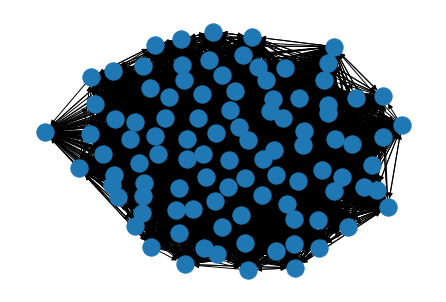

In [43]:
pos = nx.spring_layout(G)
nx.draw(G, pos)
plt.show()

In [44]:
# save the graph
nx.write_weighted_edgelist(G, "./data/money_laundrying_dataset/shp_{}_{}/weighted_{}.edgelist"\
                           .format(shp_len, shp_num, str(postive_per)))

## DeepWalk

In [45]:
p = psutil.Process(os.getpid())
p.cpu_affinity(list(range(cpu_count())))

In [46]:
logger = logging.getLogger(__name__)
LOGFORMAT = "%(asctime).19s %(levelname)s %(filename)s: %(lineno)s %(message)s"
numeric_level = getattr(logging, log_verb.upper(), None)
logging.basicConfig(format=LOGFORMAT)

In [47]:
input_file = './data/money_laundrying_dataset/shp_{}_{}/weighted_{}.edgelist'.format(shp_len, shp_num, str(postive_per))

In [48]:
if input_format == "adjlist":
    G = graph.load_adjacencylist(input_file, undirected=undirected)
elif input_format == "edgelist":
    G = graph.load_edgelist(input_file, undirected=undirected)
elif input_format == "mat":
    G = graph.load_matfile(input_file, variable_name=matfile_variable_name, undirected=undirected)
elif input_format == 'weighted_edgelist':
    G = nx.DiGraph()
    G.add_weighted_edges_from(edgelist)
else:
    raise Exception("Unknown file format: '%s'.  Valid formats: 'adjlist',\
    'edgelist', 'mat', 'weighted_edgelist'" % input_format)

In [49]:
num_walks = len(G.nodes()) * number_walks
data_size = num_walks * walk_length
print("Number of nodes: {}".format(len(G.nodes())))
print("Number of walks: {}".format(num_walks))
print("Data size (walks*length): {}".format(data_size))

if data_size < max_memory_data_size:
    print("Walking...")
    if input_format == 'weighted_edgelist':
        walks = weighted_random_walk.random_walk(G, num_paths=number_walks, \
                                                 path_length=walk_length, \
                                                 alpha=0, israndom=0)
        for i in range(len(walks)):
            walk = walks[i]
            walk = [str(val) for val in walk]
            walks[i] = walk
    else:
        walks = graph.build_deepwalk_corpus(G, num_paths=number_walks,path_length=walk_length, alpha=0)
    print("Training...")
    model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, workers=workers)
#   model.save_word2vec_format(output)
    print('Finished')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training...
Finished


In [50]:
#save the model
t = time.localtime()
tt = str(t.tm_year)+str(t.tm_mon).zfill(2)+str(t.tm_mday).zfill(2)+str(t.tm_hour).zfill(2)+str(t.tm_min).zfill(2)
output_file = './experiments/ourmodel/model_embedding_{}_{}.embeddings'.format(str(postive_per), tt)
model.wv.save_word2vec_format(output_file)

## 获取序列的embedding

In [51]:
def read_shp_emb(emb_file):
    # return type:dict
    with open(emb_file) as emb:
        data = emb.readlines()
        shp_num, shp_dim = [int(val) for val in str.split(data[0].strip('\n'))]
        dict_embs = dict()
        for i in range(1, shp_num+1):
            tmp = str.split(data[i].strip('\n'))
            key = tmp[0]
            emb = [float(val) for val in tmp[1:]]
            dict_embs[key] = emb
    return dict_embs

def down_sample(ps, size=64):
    df = pd.DataFrame({'data':ps})
    frac = size / len(ps)
    new_ps = df.sample(frac=frac, random_state=1).sort_index().reset_index()['data'].values.tolist()
    return new_ps

# def up_sampel(ps, size=64)

In [52]:
emb_file = './experiments/ourmodel/model_embedding_0.3_202106082120.embeddings'
dict_shp_embs = read_shp_emb(emb_file)

In [53]:
for i in range(shp_n):
    for j in range(shp_n):
        edge_mat[i, j] = [round(val, 1) for val in edge_mat[i, j]]

In [54]:
# get seq embeddings with the constrain of DTW threshold
dict_seq_embs = dict()
ts_num = shp_seq.shape[0]
for i in trange(ts_num):
    seq = [val for val in shp_seq[i,:] if val!=-1]
    ps = []
    for j in range(len(seq)):
        if i not in dict_seq_embs.keys():
            dict_seq_embs[i] = np.array(dict_shp_embs[str(seq[j])])
        else:
            tmp_dict = dict(Counter(edge_mat[seq[j-1], seq[j]]))
            js = round(1 - JS_divergency(freq_mat[i, j-1, :], freq_mat[i, j, :]), 1)
            if js in tmp_dict.keys():
                p = (tmp_dict[js] / sum(list(tmp_dict.values())))
            else:
                p = 0
            ps.append(p)
            dict_seq_embs[i] += np.array(dict_shp_embs[str(seq[j])])#*p# * edge_mat[seq[j-1], seq[j]]
    #down-sample
#     if len(ps) > representation_size:
#         ps = down_sample(ps, size=representation_size)
#     #up-sample
#     elif len(ps) < representation_size:
#         ps = up_sample(ps, size=representation_size)
    new_features = [np.mean(ps), np.std(ps), find_peaks(ps)[0].shape[0]]
    dict_seq_embs[i] = np.array(dict_seq_embs[i].tolist() + new_features)

100%|██████████| 2500/2500 [00:31<00:00, 78.85it/s]


In [55]:
seq_lens = []
for i in trange(ts_num):
    seq = [val for val in shp_seq[i,:] if val!=-1]
    seq_lens.append(len(seq))
np.mean(seq_lens)

100%|██████████| 2500/2500 [00:00<00:00, 23950.54it/s]


83.4456

In [247]:
# from tsfresh import extract_features
# def get_p_features(ps):
#     df = pd.DataFrame({'id':[1]*len(ps),'time': list(range(len(ps))),'values':ps})
#     features = extract_features(df, column_id='id', column_sort='time')
#     new_features = features.iloc[0,4:13].values
#     return new_features

In [248]:
# # get seq embeddings with the constrain of DTW threshold
# dict_seq_embs = dict()
# ts_num = shp_seq.shape[0]
# for i in trange(ts_num):
#     seq = [val for val in shp_seq[i,:] if val!=-1]
#     p = init_p()
#     for j in range(len(seq)):
#         if i not in dict_seq_embs.keys():
#             dict_seq_embs[i] = np.array(dict_shp_embs[str(seq[j])])
#         else:
#             tmp_dict = dict(Counter(edge_mat[seq[j-1], seq[j]]))
#             p = reduce(sum_dict,[p, tmp_dict])
#             dict_seq_embs[i] += np.array(dict_shp_embs[str(seq[j])])#*p# * edge_mat[seq[j-1], seq[j]]
#     dict_seq_embs[i]

In [249]:
def sum_dict(a,b):
    temp = dict()
    # python3,dict_keys类似set； | 并集
    for key in a.keys()| b.keys():
        #根据业务需求修改下面方法，
         temp[key] = sum([d.get(key, 0) for d in (a, b)])
    return temp

def init_p():
    p = dict()
    keys = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for key in keys:
        p[key] = 0
    return p

## Classifier

In [250]:
# features_matrix = np.asarray([model[str(node)] for node in range(len(G.nodes()))])
features_matrix = pd.DataFrame(dict_seq_embs).values.T
features_matrix.shape

(1250, 67)

In [251]:
X = features_matrix
y = seq_label
#print(X.shape, y.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(937, 67) (313, 67) (937,) (313,)


In [252]:
d = dict()
d['X_train'] = X_train
d['X_test'] = X_test
d['y_train'] = y_train
d['y_test'] = y_test

np.save('embedding_data_{}.npy'.format(str(postive_per)), d)

In [253]:
### Xgboost Classifier
model = XGBClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print('XGBoost')
print("accuracy:",accuracy_score(y_test, predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

XGBoost
accuracy: 0.7156549520766773
precision: 0.7235772357723578
f1-score 0.7999999999999999


In [254]:
### Logistic Regression Classifier 
clf = LogisticRegression(penalty='l2')
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print("Logistic Regression")
#print(classification_report(y_test,predictions))
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

Logistic Regression
accuracy: 0.6964856230031949
precision: 0.696969696969697
f1-score 0.7948164146868252


In [255]:
### Decision Tree
rfc = DecisionTreeClassifier()
rfc = rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print('Decision Tree')
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

Decision Tree
accuracy: 0.6421725239616614
precision: 0.6719367588932806
f1-score 0.752212389380531


In [256]:
### Extra Tree
clf = ExtraTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print('Extra Tree')
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

Extra Tree
accuracy: 0.6645367412140575
precision: 0.688
f1-score 0.7661469933184856


In [433]:
import numpy as np
from numpy import random

In [434]:
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
np.random.choice(aa_milne_arr, 5, p=[0.5, 0.1, 0.1, 0.3])

array(['pooh', 'pooh', 'pooh', 'pooh', 'pooh'], dtype='<U11')

## embedding 应用 baseline

In [435]:
from utils import *
import numpy as np
from pyts.classification import SAXVSM, BOSSVS
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from joblib import dump
from collections import Counter

In [436]:
clf = MLPClassifier(solver = 'sgd', activation = 'logistic', alpha=1e-4, \
                    max_iter = 1000, hidden_layer_sizes = (256,128,64,2),\
                    batch_size=32, learning_rate_init=1e-3,\
                    verbose=0, random_state = 1, shuffle=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('MLP')
print('acc:', acc)
print('prec:', prec)
print('f1:', f1)

MLP
acc: 0.6357827476038339
prec: 0.6357827476038339
f1: 0.7773437500000001


In [437]:
sgdc = SGDClassifier(loss='hinge',max_iter=1000, alpha=1e-4, shuffle=True, random_state=1)
sgdc.fit(X_train,y_train)
sgdc_predict_y = sgdc.predict(X_test)
acc = accuracy_score(y_test, sgdc_predict_y)
prec = precision_score(y_test, sgdc_predict_y)
f1 = f1_score(y_test, sgdc_predict_y)

print('SGD')
print('acc:', acc)
print('prec:', prec)
print('f1:', f1)

SGD
acc: 0.36421725239616615
prec: 0.0
f1: 0.0


In [438]:
saxvsm = SAXVSM(window_size=16, word_size=8, n_bins=5, strategy='uniform')
saxvsm.fit(X_train, y_train)
saxvsm_predict_y = saxvsm.predict(X_test)
acc = accuracy_score(y_test, saxvsm_predict_y)
prec = precision_score(y_test, saxvsm_predict_y)
f1 = f1_score(y_test, saxvsm_predict_y)

print('SAXVSM')
print('acc:', acc)
print('prec:', prec)
print('f1:', f1)

SAXVSM
acc: 0.6549520766773163
prec: 0.6491803278688525
f1: 0.7857142857142858


In [439]:
# clf = DecisionTreeClassifier().fit(X_train, y_train)
bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(),max_samples=0.5,max_features=0.5)
bagging.fit(X_train, y_train)
bagging_predict_y = bagging.predict(X_test)
acc = accuracy_score(y_test, bagging_predict_y)
prec = precision_score(y_test, bagging_predict_y)
f1 = f1_score(y_test, bagging_predict_y)

print('Bagging')
print('acc:', acc)
print('prec:', prec)
print('f1:', f1)

Bagging
acc: 0.6996805111821086
prec: 0.7058823529411765
f1: 0.7929515418502202
